# Reading in GridRad-Severe Data 

```{image} ../thumbnails/thumbnail.png
:alt: GridRad-Severe Version 4.2 logo
:width: 200px
```

---

## Overview 
For some severe weather events in the Northeast U.S., there has been some observations of severe thunderstorms being locally enhanced by the dynamics of local topography by producing a local enhancement of severe reports or lightning. Past studies such as {cite:t}`Wasula:2002`, LeBel et al. (2021) and Kramer et al. (2025) have analyzed more specific severe weather events across the central New York region and how some storms were enhanced in severity by processes such as valley channeling and vortex stretching from changes in terrain elevation. In this study, we seek to look at different severe thunderstorm events in the Northeast and study how local topography influences the intensity and distribution of these events. Similar to past studies such as Wasula et al. (2002), we will be looking at various different severe weather outbreaks and compare different synoptic environments and ambient background flows on the topography. Some examples of the differing synoptic-scale setups will be NW vs. SW flow and warm vs. cold season events. One database we will make use of in this research, along with several others, is GridRad-Severe, a gridded radar reflectivity dataset that contains radar data from over 100 stations across the CONUS. 

1. Prerequisites
2. Imports
3. Content
4. Summary
5. Conclusions
6. Resources and References

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Numpy](https://foundations.projectpythia.org/core/numpy/) | Necessary | |
| [Intro to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy) | Necessary | |
| [Understanding of Xarray](https://foundations.projectpythia.org/core/xarray/) | Helpful | Analysis of gridded datasets |
| [Understanding of Matplotlib](https://foundations.projectpythia.org/core/matplotlib/) | Helpful | Creating plots in Python |
| [Using Gridradpy Library](https://github.com/tsupinie/gridradpy) | Helpful | Specifically load in and use GridRad data | 

- **Time to learn**: About 50 minutes (10 minutes per subsection)

---

## Imports

Let's first start with importing all the necessary libraries we will need here. We will need cartopy to create maps with specified projections, in conjunction with matplotlib for making plots. We can then import xarray, which is helpful for working with and analyzing gridded datasets such as GridRad-Severe, in addition to the numpy package for scientific computing. 

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

## Content #1: Importing and Plotting a GridRad Radar Reflectivity File

One helpful way to analyze past severe thunderstorms is reading in and plotting a singular GR-S radar file to see how the structure of the storm looked on radar. We can do this by using xarray's open_dataset function to open and decode the NetCDF file. For now, I will define the file path that contains the radar file to my current research folder. I then use xarray to open the data set within the file path. The radar netCDF file is hosted by the NSF NCAR Geoscience Data Exchange (GDEX) website: https://gdex.ucar.edu/datasets/d841006/dataaccess

In [2]:
file_path = '/nfs/mulholland_lab/acolgate/Research/nexrad_3d_v4_2_20230808T001000Z.nc' 
ds = xr.open_dataset(file_path)

Let's then further inspect the dataset to understand its structure, dimensions, and variables:

In [3]:
print(ds)

<xarray.Dataset> Size: 530MB
Dimensions:                    (Sweep: 2104, Altitude: 29, Latitude: 1248,
                                Longitude: 1680, Index: 6798053, time: 1)
Coordinates:
  * Altitude                   (Altitude) float64 232B 0.5 1.0 1.5 ... 21.0 22.0
  * Latitude                   (Latitude) float64 10kB 24.01 24.03 ... 49.99
  * Longitude                  (Longitude) float64 13kB 251.5 251.5 ... 286.5
  * time                       (time) datetime64[ns] 8B 2023-08-08T00:10:00
Dimensions without coordinates: Sweep, Index
Data variables: (12/18)
    sweeps_merged              (Sweep) |S29 61kB ...
    Nradobs                    (Altitude, Latitude, Longitude) int8 61MB ...
    Nradecho                   (Altitude, Latitude, Longitude) int8 61MB ...
    index                      (Index) int32 27MB ...
    Reflectivity               (Index) float32 27MB ...
    wReflectivity              (Index) float32 27MB ...
    ...                         ...
    DifferentialRef

The radar reflectivity data is contained under the `Reflectivity` data variable. This is the variable we will plot first. 

To plot the reflectivity, we first need to reconstruct a 3D grid of reflecitivity data from 1-D data points. We do this by extracting 1D arrays from the Longitude, Latitude and Altitude data points, which calculates the number of each point on each dimension.

In [4]:
lon_vals = ds['Longitude'].values
lat_vals = ds['Latitude'].values
alt_vals = ds['Altitude'].values

Then, we initialize a 3D numpy array and fill it entirely with `np.nan` to represent missing data points:

In [5]:
nlon, nlat, nalt = len(lon_vals), len(lat_vals), len(alt_vals)
reflectivity_grid = np.full((nalt, nlat, nlon), np.nan)

Next, we decode the index since it contains the 1-D grid boxes to plot the radar reflectivity, and the actual reflectivity variable. We can use integer division and modulo operator functions to calculate longitude (i), latitude (j), and altitude (k) indexes. After that, we can finally build the 3D refl. grid by assigning the measured `refl` values to their correct 3D coordinates. 

In [6]:
index = ds['index'].values
refl = ds['Reflectivity'].values

k = index // (nlat * nlon)
j = (index % (nlat * nlon)) // nlon
i = index % nlon

reflectivity_grid[k, j, i] = refl

Next, we find the maximum value in the reflectivity grid along the altitude dimension, then create a masked array that hides any max. values that are equal to 0 or less than five:

In [7]:
colmax_refl = np.nanmax(reflectivity_grid, axis=0)  
colmax_masked = np.ma.masked_where(np.isnan(colmax_refl) | (colmax_refl < 5), colmax_refl)

/tmp/ipykernel_3498403/2232845460.py:1: RuntimeWarning: All-NaN slice encountered
  colmax_refl = np.nanmax(reflectivity_grid, axis=0)


Next, we define the interval for data sampling. In this case, it would be 1 to make sure every data variable is selected.

In [8]:
step = 1
lons = lon_vals[::step] # Slice the lon_vals and lat_vals arrays, so lons and lats become copies of all variables in lon_vals and lat_vals
lats = lat_vals[::step]
colmax_ds = colmax_masked[::step, ::step] # Slice a 2D array and select all rows and all columns
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals) # Use meshgrid to generate all possible lat/lon pairs that form a rectangular grid

Then, let's get to actually plotting this. I mainly used matplotlib functions here to plot the Column-Max Reflectivity, using a smoother type of shading so that the reflectivity looks more higher resolution. We add map features such as states, borders, and coastlines. I then wanted to center the plot over the Turin, NY area, which was the focus around a study by Kramer et al. (2025). The town got hit with a tornadic supercell that produced an EF3 tornado around 0000Z on August 8th, 2023. We can look the radar reflectivity at that time to analyze the supercell, and also set a lat/lon extent centered over that region to get a clearer view. 

For this, it would be best to make a colormesh plot, and we can use matplotlib functions to make a colorbar, add map features, make gridlines and a plot title. Also, I set a lat/lon extent which was centered over upstate NY around the Turin, NY area. 

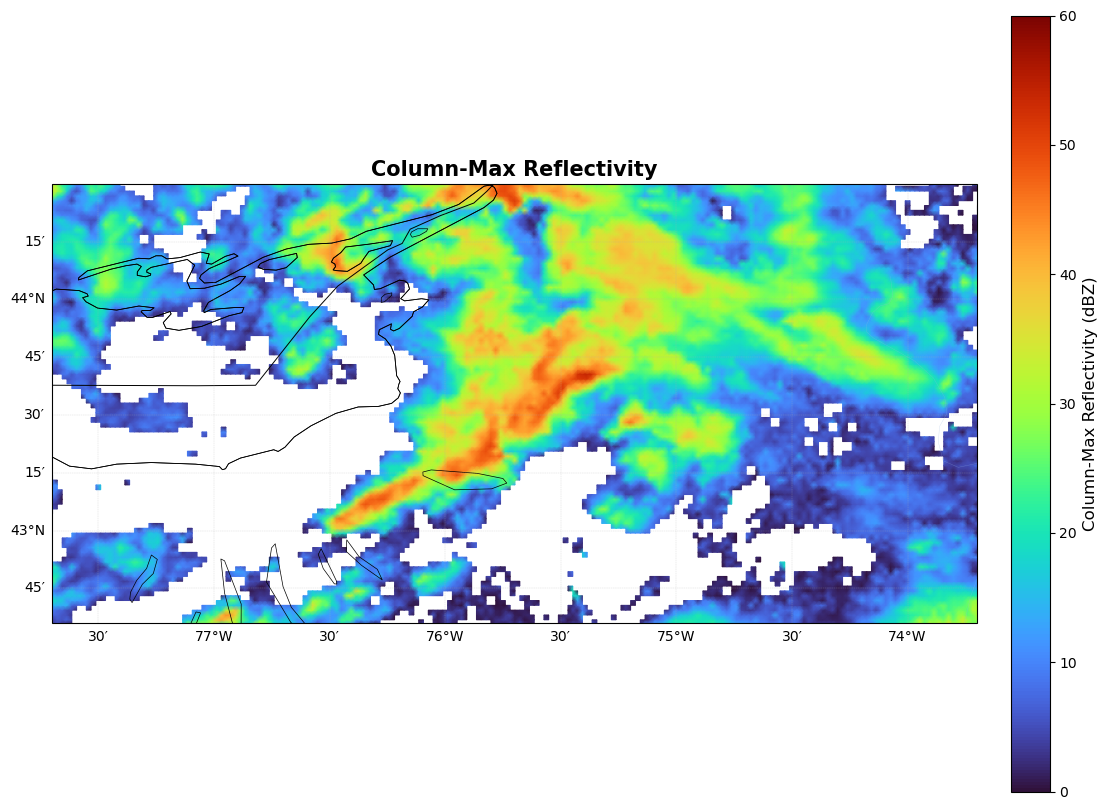

In [9]:
fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10)) # Create the matplotlib figure 

pcm = ax.pcolormesh( # Add colormesh plot 
    lon_grid, lat_grid, colmax_refl,
    cmap='turbo',          # Use 'turbo' colormap which is best for plotting dBZ values 
    vmin=-0, vmax=60,  # Set minimum and maximum values to 60, which is typical for a refl. plot
    shading='gouraud',      # Add this to make the data pixels a bit smoother 
    transform=ccrs.PlateCarree() # We use PlateCarree map projection for lat/lon 
)

cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.8, pad=0.03)
cbar.set_label('Column-Max Reflectivity (dBZ)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

# Map features
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.6)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.7)
ax.add_feature(cfeature.LAKES.with_scale('50m'), edgecolor='black', facecolor='none', linewidth=0.5)
ax.add_feature(cfeature.RIVERS.with_scale('50m'), linewidth=0.3, alpha=0.4)
ax.coastlines(resolution='50m', linewidth=0.7)

extent = [-77.7, -73.7, 42.6, 44.5]

ax.set_extent(extent, crs=ccrs.PlateCarree()) 

gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.5, linewidth=0.3, linestyle='--')
gl.top_labels = False
gl.right_labels = False

ax.set_title('Column-Max Reflectivity', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

The supercell centered over the Turin, NY area can be seen clearly in the above graph. 

:::{note}
GridRad data is severely skewed to the low-end of its distribution, so some deeper reflectivity colors, like what would be typically seen in a NWS radar image might not show up as well. The maximum and minimum values might have to be modified a bit to make it look more realistic. 
:::

## Content #2: Plotting the Azimuthal Shear 

As seen earlier when we read in the datafile, radar reflectivity is not the only data variable we can plot. Another variable that would be helpful to measure any areas of rotation is the azimuthal shear, or the change in wind velocity over a distance in the horizontal direciton, measured in s^-1. This is a common variable that is used in the study of mesocyclones, and is represented in the GR-S dataset by the variable `AzShear`.

We can set this up very similary to how we defined the reflectivity grid, except this time we base it around the 'AzShear' data variable. 

In [10]:
lon_vals = ds['Longitude'].values
lat_vals = ds['Latitude'].values
alt_vals = ds['Altitude'].values

nlon, nlat, nalt = len(lon_vals), len(lat_vals), len(alt_vals)

azshear_grid = np.full((nalt, nlat, nlon), np.nan, dtype=np.float32)

index = ds['index'].values
azshear = ds['AzShear'].values

k = index // (nlat * nlon)
j = (index % (nlat * nlon)) // nlon
i = index % nlon

azshear_grid[k, j, i] = azshear

We once again use numpy arrays to calculate the AZ shear values on the first axis, and remove any dimensions of size 1 from the 'colmax_azshear' array by using numpy's `squeeze` function. 

In [11]:
colmax_azshear = np.nanmax(azshear_grid, axis=0)
colmax_azshear = np.squeeze(colmax_azshear)

/tmp/ipykernel_3498403/3185089806.py:1: RuntimeWarning: All-NaN slice encountered
  colmax_azshear = np.nanmax(azshear_grid, axis=0)


We can then make the plot using very similar functions to the reflectivity plot. We first create the rectangular grid by creating two 2-D arrays and create objects for a color plot. Here, it is more applicable to use a diverging colormap ("RuBu_r") for positive (red) and negative (blue) values. For MRMS AzShear values, it works best to set minimum and maximum values of -0.005 and 0.005 for the color scale. Then, use the same shading option to smooth the pixels. Finally, we can use the same map features, zoom extent, and colorbar settings that we used before. 

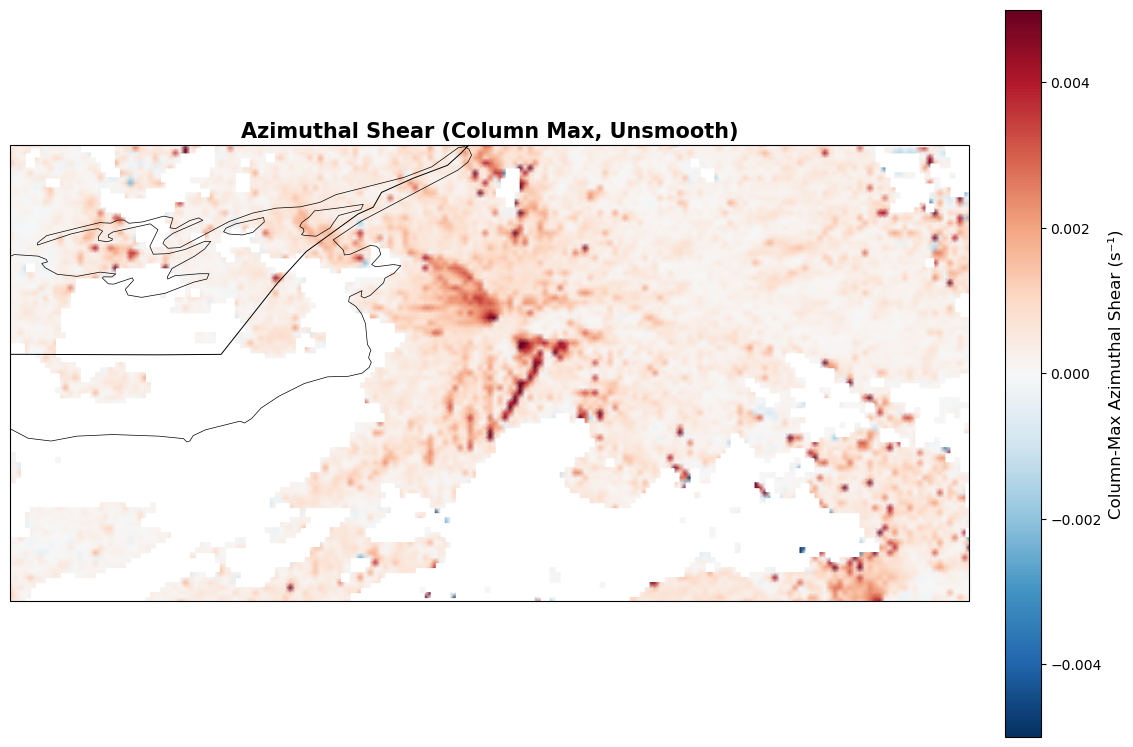

In [12]:
lon_grid, lat_grid = np.meshgrid(lon_vals, lat_vals)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(12, 10))

pcm = ax.pcolormesh(
    lon_grid, lat_grid, colmax_azshear,
    cmap='RdBu_r',          
    vmin=-0.005, vmax=0.005,  
    shading='gouraud',     
    transform=ccrs.PlateCarree()
)

ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5)
ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.7)
ax.coastlines(resolution='50m')

extent = [-77.7, -73.7, 42.6, 44.5]
ax.set_extent(extent, crs=ccrs.PlateCarree())

cbar = plt.colorbar(pcm, ax=ax, orientation='vertical', shrink=0.75, pad=0.03)
cbar.set_label("Column-Max Azimuthal Shear (s⁻¹)", fontsize=12)
cbar.ax.tick_params(labelsize=10)

ax.set_title("Azimuthal Shear (Column Max, Unsmooth)", fontsize=15, weight='bold')
plt.tight_layout()
plt.show()

While a bit grainy, you can make out a maximum of AZ shear values above 0.004 s^-1 in the Turin supercell, as well as some other maximas in surrounding cells. 

---

## Summary

All in all, it can be seen from the graphs shown here that GridRad-Severe data can be very helpful in looking at past radar reflectivity data to study past severe thunderstorm events and look at various severe weather variables. You can look at netCDF files pulled from all severe weather days from 2010-2023 and plot the reflectivity data for each day at 5-minute intervals. This can be helpful in looking at the structure of thunderstorms or storm clusters, or even the entire structure of a storm system. For example, we looked at the August 7th, 2023 Turin, NY supercell in this notebook. In conjunction with the radar data, you can study other severe variables such as the Azimuthal Shear to further analyze the severity and environmental conditions of severe thunderstorms. As was shown in the second plot in this notebook, a maxima of AZ shear can be seen in the center of the Turin supercell, indicating strong rotation in the storm, which lines up with severe reports at the surface. 

## Resources and references

Murphy, A. M., Homeyer, C. R., and Allen, K. Q.: Development and investigation of gridrad-severe, a multi-year severe event radar dataset, Mon. Weather Rev., 151, 2257–2277, https://doi.org/10.1175/MWR-D-23-0017.1, 2023. 

Kramer, Alex D., "The Influence of Complex Terrain on the Turin, New York Tornado of 2023" (2025). Atmospheric and Environmental Sciences Honors Program. 1.
https://scholarsarchive.library.albany.edu/cas-daes-honors/1 

https://gridrad.org/data.html
https://gdex.ucar.edu/datasets/d841006/